In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [9]:
from matplotlib import pyplot as plt
from matplotlib import colors as colors
import numpy as np

import sys 
#sys.path.append('../')

from importlib import reload
import Utils.utils as util
reload(util)


from sklearn.linear_model import Lasso
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import normalize

np.set_printoptions(threshold=np.inf) #print full arrays
from sklearn import linear_model


In [10]:
def split_patch(patch):
    h = patch.shape[0]
    #Convert one patch into a column vector for training
    patch = patch.flatten()
    pixel_central = patch[(h*(h//2)+(h//2))*3:(h*(h//2)+(h//2))*3+3]
    patch_sans_central = np.delete(patch, range((h*(h//2)+(h//2))*3, (h*(h//2)+(h//2))*3+3))
    return np.array((patch_sans_central, pixel_central))
    
def convert_patch_into_vector(patch):
    #Convert one patch into a column vector for training
    #patch = patch.flatten()
    h = patch.shape[0]
    patch = np.reshape(patch, h*h*3)
    return np.array(patch)

def convert_vector_into_patch(vector, h):
    #Convert a one column vector into a patch of size h
    return vector.reshape((h,h,7))
    
def convert_patches_into_training_set(patches):
    #Convert a set of patches into a set of vectors
    return np.array(list(map(convert_patch_into_vector, patches))).T

def find_index_noisy_lines(label):
    """
    indexes = []
    for index, value in enumerate(label):
        if(value == -1):
            indexes.append(index)
    """
    label = np.array(label)
    indexes = np.where(label < 0)
    return indexes

def delete_all_indexes_from(dictionary, label):
    indexes = find_index_noisy_lines(label)
    dictionary = np.delete(dictionary, indexes , 0)
    label = np.delete(label, indexes , 0)
    
    return (dictionary, label)    

#test the alpha on a lot of cleared patches and returns an average value
def estimate_alpha(noisy_image, dictionary_full, h):
    lassocv = linear_model.LassoCV()
    listalpha = []
    width = noisy_image.shape[1]
    height = noisy_image.shape[0]
    #params
    pas = h+10
    start = h//2
    endx = height-h//2
    endy = width-h//2
    #end params
    i=0
    total = int( (endx-pas)/pas * (endy-pas)/pas )
    for x in range(start,endx,pas):
        for y in range(start,endy,pas):
            label = util.get_patch(x, y, h, noisy_image)
            label = list(convert_patch_into_vector(label))
            dictionary, label = delete_all_indexes_from(dictionary_full,label)
            lassocv.fit(dictionary_full, label)
            alpha_ = lassocv.alpha_
            listalpha.append(alpha_)
            i+=1
            if(i%10==0): print(i, "/", total)
    return np.mean(np.array(listalpha))
    
def removearray(L,arr):
    ind = 0
    size = len(L)
    while ind != size and not np.array_equal(L[ind],arr):
        ind += 1
    if ind != size:
        L.pop(ind)
    else:
        #raise ValueError('array not found in list.') #todo, why am I getting this one in optimized mode
        print('ERROR:  removearray(L,arr): array not found in list.')

def inpaint_image(noisy_image, dictionary, coord_noisy_pix, h, clear_image):
    noisy_image_orig = np.array(noisy_image)
    dictionary_full = np.array(dictionary)
    
    #todo question: vérifier qu'il faut bien faire le lassocv pour trouver le alpha sur le clear?
    lassocv = linear_model.LassoCV(max_iter=1000)  #1000 by default, 100 works OK most of the time
    """
    y, x = coord_noisy_pix[0]
    label = util.get_patch(x, y, h, noisy_image)
    #label = util.get_patch(x, y, h, clear_image)
    label = list(convert_patch_into_vector(label))
    lassocv.fit(dictionary_full, label)
    alpha_ = lassocv.alpha_
    """
    #alpha_ = estimate_alpha(noisy_image, dictionary_full, h)
    #autre idée: en prendre 10 aléatoirement ?
    alpha_ = 0.01 #default value
    
    print("alpha = ", alpha_)
       
    i = 0
    nbiter  = int(len(coord_noisy_pix))
    while i < nbiter: # DONT USE FOR FOR THIS BECAUSE WE WILL MODIFY THE LIST
        y, x  = coord_noisy_pix[i] 
        
        #utile pour la correction des carrés manquants
        while( not(np.all(noisy_image[x][y] == -1 )) and i < nbiter):
            #print("PIXEL ",x,y," DEJA CORRIGE")
            if(i%10==0): print( i, " / ",  nbiter)
            i=i+1
            y, x  = coord_noisy_pix[i] 
        
        if(i%10==0): print( i, " / ",  nbiter)
        
        #print("Correction de : (", x, ", ", y,")")
        patch = util.get_patch2(x, y, h, noisy_image)
        labelfull = list(convert_patch_into_vector(patch))
        
        #print("labelfull : ", labelfull)
        
        dictionary = np.array(dictionary_full)
        dictionary, label = delete_all_indexes_from(dictionary,labelfull)

        #print("--- lasso regression ---")
        
        #recalcule du alpha à chaque patch
        lassocv.fit(dictionary, label)
        alpha_ = lassocv.alpha_
        print("alpha = ", alpha_)
        #fin recalcule du alpha
        
        model = Lasso(fit_intercept=True,alpha=alpha_,positive=True)
        
        model.fit(dictionary, label)
        
        #################################################
        #version somme cumulée pondérée
        #res = model.predict(dictionary_full)
        
        #version argmax
        #print("argmax = ",np.argmax(model.coef_)," / ", model.coef_.shape)
        res = dictionary_full.T[np.argmax(model.coef_)]
        #################################################
        
        #################################################
        #coef = model.coef_.reshape((1,-1)) #poids
        #print("nb patch not at zero: ", np.count_nonzero(model.sparse_coef_.toarray()), " / ", coef.shape[1])
       
        # corrige juste le pixel central
        #"""
        # and use y, x = coord_noisy_pix[i]  at the beginning of the while
        newPixel = util.get_centered_pixel(res, h)
        print("new pixel (lasso): ", newPixel)
        noisy_image[x][y] = newPixel
        i=i+1
        #"""
        
        """
        # corrige tous les pixels noirs dans le patch
        labelfull = np.array(labelfull)
        list_indexes_noise = np.where(labelfull == -1)[0]     
        #print(list_indexes_noise)   
        indexeach3 = list(range(0,len(list_indexes_noise),3))
        listindexes2 = list_indexes_noise[indexeach3] #on prend que 1 sur 3 car 3 valeurs par pixel
        xpatch = x-h//2
        ypatch = y-h//2
        i=i+1
        for val in listindexes2:
            val = (val/3)
            ylocal = int((val)//h)
            xlocal = int(val-(ylocal)*h)
            #print("xlocal = ",xlocal," ylocal=",ylocal)
            xglobal = xpatch + xlocal
            yglobal = ypatch + ylocal
            print("correcting pixel (",xglobal,", ",yglobal,")")
            #print("xglobal=",xglobal," yglobal=",yglobal)
            patch = res.reshape(h,h,3)
            newpixel = patch[xlocal, ylocal]
            noisy_image[xglobal][yglobal] = newpixel
            ##########################
            ##supprimer de la liste pour pas le refaire #obsolète on ne fait plus ça
            #coord_noisy_pix = list( coord_noisy_pix)
            #currentpixel = [xglobal, yglobal] #ok vérifié
            ##print("remove : ", currentpixel)
            #removearray(coord_noisy_pix, np.array(currentpixel))
            #coord_noisy_pix = list( coord_noisy_pix)
            ##print("left to correct : ",len(coord_noisy_pix))
            #i = i + 1
            #if(i%10==0):
            #    print( i, " / ",  nbiter)
            ##########################
            
        #util.display_im(noisy_image)
       #"""    
        #################################################
        
        #Test  -> reconstruire de nouveaux patch à partir des pixels corrigés ?
        #_,clear_patches = util.get_patches(noisy_image, h, width, height)
        #dictionary_full = convert_patches_into_training_set(clear_patches)
        #print("shape : ", dictionary_full.shape)

    util.display_im(noisy_image_orig)
    util.display_im(noisy_image)

taille de l'image :  (100, 100, 3)
nb pixels à corriger:  199
nbclear pacthes: 395


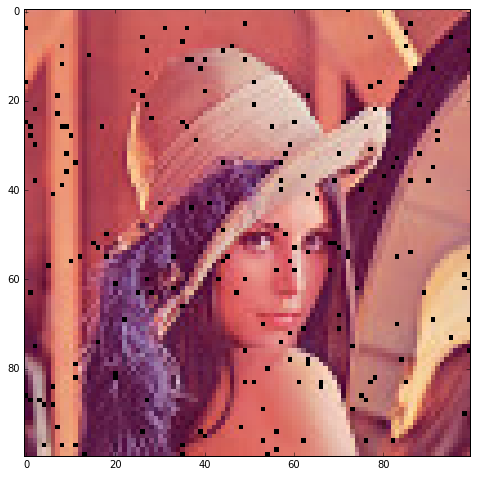

In [11]:
%matplotlib inline
img_matrice = util.read_im("Data/imgdataset/lennasmall.jpg")
#lennasmall.jpg

print("taille de l'image : ", img_matrice.shape)

#util.display_im(img_matrice)

#Taille des patchs
h=5 #nombre impair !!

width = img_matrice.shape[1]
height = img_matrice.shape[0]
noisy_image, deletepixels = util.noise2(img_matrice, 0.02, width, height, h);

#noisy_image, deletepixels = util.delete_rect(img_matrice, 10, 10, 10, 10) #66, 55, 75, 15

#10small 65, 50, 80, 15
#12.jpg 85, 75, 30, 6

print("nb pixels à corriger: ", np.array(deletepixels).shape[0])

width = img_matrice.shape[1]
height = img_matrice.shape[0]

#print(width," , ", height)

util.display_im(noisy_image)

_,clear_patches = util.get_patches(noisy_image, h, width, height)

nbclear = np.shape(clear_patches)[0]
print("nbclear pacthes:", nbclear)

In [12]:
training = convert_patches_into_training_set(clear_patches)
print(training.shape)

#test de l'extension d'image
#newimg = util.extend_image(noisy_image, h)
#util.display_im(newimg)

(75, 395)


In [13]:
a = np.array([[1, 'a'], [2, 'a'], [3, 'a'], [4, 'a'], [5, 'a'], [6, 'a'], [7, 'a'], [8, 'a'], [9, 'a']])
#print(a.shape)    
a = a.reshape(3,3,2)
#print(a.shape)
#print("center=",util.get_centered_pixel(a, 3))

#coefsize = (1, 2510)   dicofullsize = (27, 2510)  ressize= (27, 2510)
coef = np.array([0,1,2])
coef = coef.reshape(-1,1)
#print(coef.shape)
dico = [1,2,3]
coef.T*dico

#util.spyral_transformation(a)

array([[0, 2, 6]])

1  2  3  4
5  6  7  8
9 10 11 12

> 2
spyral_transformation(a): tab is not of 3 dimensions, doing nothing
alpha =  0.01
0  /  199


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  6.62051662613
new pixel (lasso):  [216 142 107]
alpha =  196.609547829
new pixel (lasso):  [218 101  92]
alpha =  578.489520344
new pixel (lasso):  [220 156 108]
alpha =  270.048539755
new pixel (lasso):  [224  97  91]
alpha =  263.28073349
new pixel (lasso):  [236 185 130]
alpha =  55.2602592728
new pixel (lasso):  [87 21 67]
alpha =  23.659201732
new pixel (lasso):  [83 24 68]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  4.63762948167
new pixel (lasso):  [106  46  97]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  1.78179201102
new pixel (lasso):  [123  74 121]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  587.351100671
new pixel (lasso):  [148  49  69]
10  /  199


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  8.22595630282
new pixel (lasso):  [221 188 181]
alpha =  294.959221925
new pixel (lasso):  [168  76  81]
alpha =  95.7821633382
new pixel (lasso):  [168  76  81]
alpha =  10.6020641691
new pixel (lasso):  [202 127 132]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  12.2550592365
new pixel (lasso):  [220 114 100]
alpha =  10.360392247
new pixel (lasso):  [110  51  99]
alpha =  49.4860216863
new pixel (lasso):  [242 202 194]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.09555702583
new pixel (lasso):  [233 173 163]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  844.573615957
new pixel (lasso):  [112  28  61]
alpha =  331.336899961
new pixel (lasso):  [218 101  92]
20  /  199
alpha =  1362.38535307
new pixel (lasso):  [220 104 104]
alpha =  129.103259515
new pixel (lasso):  [224  97  91]
alpha =  66.1672557234
new pixel (lasso):  [236 185 130]
alpha =  7.31578209544
new pixel (lasso):  [78 21 66]
alpha =  156.666094048
new pixel (lasso):  [101  19  65]
alpha =  227.379764747
new pixel (lasso):  [224  97  91]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.57784201389
new pixel (lasso):  [208 147 129]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.46712943673
new pixel (lasso):  [205 122 104]
alpha =  32.567870799
new pixel (lasso):  [202 122 115]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.99636420469
new pixel (lasso):  [242 211 164]
30  /  199


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  5.45698717286
new pixel (lasso):  [210 106  97]
alpha =  1137.88650398
new pixel (lasso):  [112  28  61]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  33.2488613625
new pixel (lasso):  [226 109 102]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.13044039352
new pixel (lasso):  [197  89  89]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.14970517224
new pixel (lasso):  [105  59  98]
alpha =  13.2489755232
new pixel (lasso):  [232 143 113]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  8.59453470871
new pixel (lasso):  [255 208 162]
alpha =  97.1748222601
new pixel (lasso):  [224  97  91]
alpha =  135.722318914
new pixel (lasso):  [220 119 127]
alpha =  11.7453352972
new pixel (lasso):  [232 143 113]
40  /  199


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.19887649653
new pixel (lasso):  [209 137 151]
alpha =  7.46398672486
new pixel (lasso):  [255 208 162]
alpha =  14.338636841
new pixel (lasso):  [106  46  97]
alpha =  271.466913649
new pixel (lasso):  [224  97  91]
alpha =  121.613150861
new pixel (lasso):  [230 132 107]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  565.153958376
new pixel (lasso):  [205  84  89]
alpha =  59.8978273824
new pixel (lasso):  [123  59  94]
alpha =  86.3416363074
new pixel (lasso):  [233 148 117]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  6.33130630343
new pixel (lasso):  [221 188 181]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  14.1351701842
new pixel (lasso):  [112  28  61]
50  /  199


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  8.91209372741
new pixel (lasso):  [224  97  91]
alpha =  63.6166342129
new pixel (lasso):  [216 142 107]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.16721373457
new pixel (lasso):  [150  84 130]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  7.55480905921
new pixel (lasso):  [83 24 68]
alpha =  59.4028172474
new pixel (lasso):  [221 102  96]
alpha =  926.030898063
new pixel (lasso):  [204 112 117]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.29379899181
new pixel (lasso):  [137  94 104]
alpha =  121.231129531
new pixel (lasso):  [218 101  92]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.23751977862
new pixel (lasso):  [216 142 107]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  6.16862383165
new pixel (lasso):  [208 147 129]
60  /  199
alpha =  941.176530309
new pixel (lasso):  [233 148 117]
alpha =  213.211626254
new pixel (lasso):  [224  97  91]
alpha =  187.385068225
new pixel (lasso):  [224  97  91]
alpha =  122.630115392
new pixel (lasso):  [95 23 60]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  326.998573943
new pixel (lasso):  [226 132 107]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.43273278733
new pixel (lasso):  [192  92  90]
alpha =  82.1836283011
new pixel (lasso):  [185  72  74]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  307.019427198
new pixel (lasso):  [234 227 211]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  7.92728493115
new pixel (lasso):  [83 24 68]
alpha =  13.7348222567
new pixel (lasso):  [99 37 78]
70  /  199
alpha =  35.5837511878
new pixel (lasso):  [242 211 164]
alpha =  171.266681475
new pixel (lasso):  [224  97  91]
alpha =  111.510954513
new pixel (lasso):  [224  97  91]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.53884940139
new pixel (lasso):  [168  76  81]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  17.766799714
new pixel (lasso):  [224  97  91]
alpha =  53.4482827467
new pixel (lasso):  [216 142 107]
alpha =  114.364754115
new pixel (lasso):  [162  88 103]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.44369053948
new pixel (lasso):  [236 185 130]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  144.074232099
new pixel (lasso):  [237 142 110]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  341.367933945
new pixel (lasso):  [233 173 163]
80  /  199


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  6.83311216633
new pixel (lasso):  [229 167 142]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  49.4862638657
new pixel (lasso):  [176  65  81]
alpha =  31.449668433
new pixel (lasso):  [215 194 173]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.15007893363
new pixel (lasso):  [85 21 71]
alpha =  34.5918933936
new pixel (lasso):  [105  59  98]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  1.83786921296
new pixel (lasso):  [196 158 169]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  24.6795712098
new pixel (lasso):  [224  97  91]
alpha =  267.020861203
new pixel (lasso):  [158 126 175]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  141.561981217
new pixel (lasso):  [156  93 138]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  4.28349449052
new pixel (lasso):  [224 201 187]
90  /  199


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  12.12391182
new pixel (lasso):  [255 224 179]
alpha =  55.3180476629
new pixel (lasso):  [100  35  78]
alpha =  96.6536055748
new pixel (lasso):  [224  97  91]
alpha =  17.8831967862
new pixel (lasso):  [255 208 162]
alpha =  150.770636421
new pixel (lasso):  [236 185 130]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  54.7965649129
new pixel (lasso):  [128  71 124]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  11.0699310368
new pixel (lasso):  [92 23 67]
alpha =  60.8666917839
new pixel (lasso):  [222 107 100]
alpha =  218.255050253
new pixel (lasso):  [224  97  91]
alpha =  544.91058687
new pixel (lasso):  [218 101  92]
100  /  199


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  8.22625273802
new pixel (lasso):  [186 125 124]
alpha =  12.4823828461
new pixel (lasso):  [128  71 124]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.86373090278
new pixel (lasso):  [186 125 124]
alpha =  559.349377913
new pixel (lasso):  [218 101  92]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  12.3468716699
new pixel (lasso):  [237 207 171]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  5.48716244229
new pixel (lasso):  [85 15 69]
alpha =  40.1938966062
new pixel (lasso):  [196 158 169]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  38.4050390519
new pixel (lasso):  [146  62  75]
alpha =  99.3757840788
new pixel (lasso):  [224  97  91]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  7.06376522467
new pixel (lasso):  [158 126 175]
110  /  199
alpha =  233.501228607
new pixel (lasso):  [224  97  91]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.26100580805
new pixel (lasso):  [106  46  97]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  1.84755806327
new pixel (lasso):  [168  76  81]
alpha =  7.96579569448
new pixel (lasso):  [163 110 154]
alpha =  6.16772963251
new pixel (lasso):  [110  51  99]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.17725868056
new pixel (lasso):  [186 125 124]
alpha =  285.785735503
new pixel (lasso):  [224  97  91]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  15.2814595633
new pixel (lasso):  [176  65  81]
alpha =  193.134787796
new pixel (lasso):  [224  97  91]
alpha =  264.931602899
new pixel (lasso):  [224  97  91]
120  /  199


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  6.02269360804
new pixel (lasso):  [176  61  74]
alpha =  316.574537037
new pixel (lasso):  [224  97  91]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  6.08099095534
new pixel (lasso):  [233 173 163]
alpha =  89.2290761117
new pixel (lasso):  [100  24  63]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  38.8259021825
new pixel (lasso):  [189  72  80]
alpha =  11.4827006047
new pixel (lasso):  [210 103  97]
alpha =  33.5743600703
new pixel (lasso):  [255 208 162]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.58951357814
new pixel (lasso):  [207 106  98]
alpha =  23.1926181561
new pixel (lasso):  [211  92  98]
alpha =  161.449465514
new pixel (lasso):  [218 101  92]
130  /  199
alpha =  494.487355709
new pixel (lasso):  [218 101  92]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.03910021178
new pixel (lasso):  [224 201 187]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  17.4492188598
new pixel (lasso):  [237 207 171]
alpha =  9.51044887649
new pixel (lasso):  [156  93 138]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.66809259259
new pixel (lasso):  [118  44  79]
alpha =  271.748720509
new pixel (lasso):  [233 173 163]
alpha =  87.552265527
new pixel (lasso):  [224  97  91]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  8.75718023157
new pixel (lasso):  [157  97 107]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  92.8050512658
new pixel (lasso):  [201 111 137]
alpha =  11.9206885907
new pixel (lasso):  [243 208 168]
140  /  199
alpha =  29.9428112642
new pixel (lasso):  [112  28  61]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.7603024324
new pixel (lasso):  [242 202 194]
alpha =  222.518957188
new pixel (lasso):  [85 12 57]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  28.5839555372
new pixel (lasso):  [151  89 136]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  177.824679973
new pixel (lasso):  [224  97  91]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  1.97902874228
new pixel (lasso):  [125  67 105]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.0387492284
new pixel (lasso):  [148  49  69]
alpha =  1138.64290449
new pixel (lasso):  [229 142 115]
alpha =  375.155150416
new pixel (lasso):  [224  97  91]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  16.5250508163
new pixel (lasso):  [204  94  93]
150  /  199


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  43.6012031231
new pixel (lasso):  [228 138 111]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  4.38907613073
new pixel (lasso):  [197  89  89]
alpha =  85.1563661718
new pixel (lasso):  [189  78  84]
alpha =  46.6371216443
new pixel (lasso):  [126  42  76]
alpha =  203.797016353
new pixel (lasso):  [236 185 130]
alpha =  7.33095716999
new pixel (lasso):  [176  61  74]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  13.4473870354
new pixel (lasso):  [223  96 103]
alpha =  52.0819239065
new pixel (lasso):  [176  61  74]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  10.7320102944
new pixel (lasso):  [219 193 170]
alpha =  256.917272212
new pixel (lasso):  [224  97  91]
160  /  199


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  6.88038096883
new pixel (lasso):  [97 25 71]
alpha =  148.305487449
new pixel (lasso):  [218 101  92]
alpha =  97.1347550588
new pixel (lasso):  [233 148 117]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.83160253009
new pixel (lasso):  [118  64 126]
alpha =  13.3481833935
new pixel (lasso):  [246 202 153]
alpha =  133.042286787
new pixel (lasso):  [95 19 66]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.29075557855
new pixel (lasso):  [197  89  89]
alpha =  55.5431175153
new pixel (lasso):  [206 136 136]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.68923695713
new pixel (lasso):  [158 126 175]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.73672213509
new pixel (lasso):  [233 150 120]
170  /  199


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  7.36617379895
new pixel (lasso):  [237 207 171]
alpha =  53.517008944
new pixel (lasso):  [156  93 138]
alpha =  96.2065279009
new pixel (lasso):  [224  97  91]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  134.896888736
new pixel (lasso):  [94 19 58]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  6.47868286369
new pixel (lasso):  [93 30 73]
alpha =  31.070752994
new pixel (lasso):  [218 101  92]
alpha =  85.8167709416
new pixel (lasso):  [158 126 175]
alpha =  710.743710179
new pixel (lasso):  [233 148 117]
alpha =  161.303474132
new pixel (lasso):  [218 101  92]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  23.512069747
new pixel (lasso):  [224 201 187]
180  /  199
alpha =  442.792046861
new pixel (lasso):  [218 101  92]
alpha =  61.9236779228
new pixel (lasso):  [211 114 105]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  19.9702625563
new pixel (lasso):  [176  65  81]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  4.01299614198
new pixel (lasso):  [166  69  76]
alpha =  32.3947936343
new pixel (lasso):  [106  46  97]
alpha =  30.0632640749
new pixel (lasso):  [218 154 155]
alpha =  333.672663757
new pixel (lasso):  [236 185 130]
alpha =  28.5493180047
new pixel (lasso):  [236 185 130]
alpha =  213.076924527
new pixel (lasso):  [166  69  76]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.99998324562
new pixel (lasso):  [204 114 124]
190  /  199


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  1.24777893519
new pixel (lasso):  [217 169 159]
alpha =  168.662106428
new pixel (lasso):  [210  92  90]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  10.9422952141
new pixel (lasso):  [151  89 136]
alpha =  184.86870735
new pixel (lasso):  [224  97  91]
alpha =  213.833019294
new pixel (lasso):  [226 109 102]
alpha =  16.3773632562
new pixel (lasso):  [137  94 104]
alpha =  253.830100135
new pixel (lasso):  [249 206 190]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  13.234111897
new pixel (lasso):  [236 185 130]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  7.91721361305
new pixel (lasso):  [234 227 211]


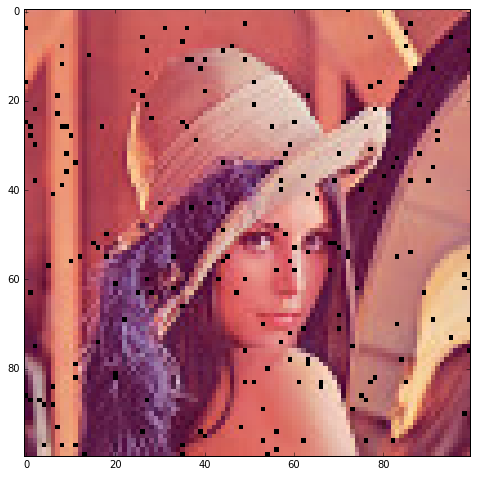

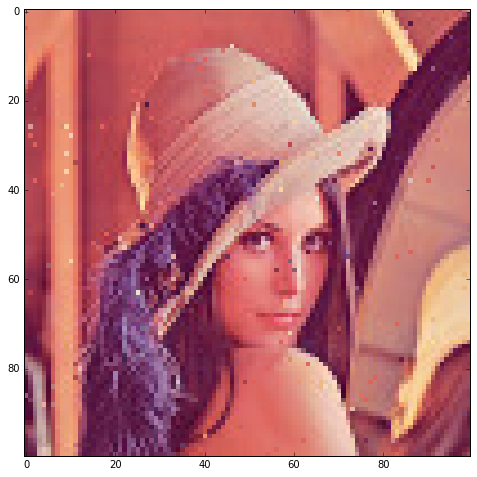

In [14]:
deletepixels_transformed = util.spyral_transformation(np.array(deletepixels))

inpaint_image(noisy_image, training, deletepixels_transformed, h, img_matrice)